# The goal of this notebook, is to create a linear interpolation between a sample with glasses and one without in latent space in order to modify any image of a person to have glasses. This can be recreated with ANY facial feature.

I referenced: https://github.com/woctezuma/stylegan2-projecting-images

## Requirements

### Switch to Tensorflow 1.x

The default TensorFlow version in Colab switched from  1.x to 2.x on the 27th of March, 2020.

Reference: https://colab.research.google.com/notebooks/tensorflow_version.ipynb

We switch to version 1.x to avoid the following error:
> `ModuleNotFoundError: No module named 'tensorflow.contrib' colab`

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


### Install StyleGAN2

Reference: https://github.com/NVlabs/stylegan2

In [2]:
%cd /content/

/content


In [3]:
%rm -rf stylegan2/
!git clone https://github.com/woctezuma/stylegan2.git

Cloning into 'stylegan2'...
remote: Enumerating objects: 220, done.
remote: Total 220 (delta 0), reused 0 (delta 0), pack-reused 220
Receiving objects: 100% (220/220), 1.56 MiB | 1.17 MiB/s, done.
Resolving deltas: 100% (117/117), done.


In [4]:
%cd stylegan2/

/content/stylegan2


In [5]:
!nvcc test_nvcc.cu -o test_nvcc -run

CPU says hello.
GPU says hello.


### Mount Google Drive

In [6]:
!pip install Google-Colab-Transfer

In [7]:
import colab_transfer

In [8]:
colab_transfer.mount_google_drive()

Mounted at /content/drive/


#### Import latent boundary made from the SVM

In [9]:
archive_name = 'glasses_latent_direction.tar.gz'
folder_name = 'latent_direction'
colab_transfer.copy_file(file_name=archive_name,
                         destination= colab_transfer.get_path_to_home_of_local_machine() + "stylegan2/")

Copying /content/drive/My Drive/glasses_latent_direction.tar.gz to /content/stylegan2/glasses_latent_direction.tar.gz


In [10]:
!du -sh $archive_name
!tar -xvf $archive_name       

40K	glasses_latent_direction.tar.gz
latent_direction/
latent_direction/glasses_latent_direction.npy


##Here's a link to my boundary, if you were interested https://drive.google.com/file/d/1OjZbjKPMxpLQKBRhupLHnwsDXrOTZmf_/view?usp=sharing

## Image data

#### Import the latent vector of the image you want to modify

In [12]:
archive_name = 'generated_images_no_tiled.tar.gz'       

colab_transfer.copy_file(file_name=archive_name,destination=colab_transfer.get_path_to_home_of_local_machine() + 'stylegan2/')

!du -sh $archive_name
!tar -xf $archive_name

Copying /content/drive/My Drive/generated_images_no_tiled.tar.gz to /content/stylegan2/generated_images_no_tiled.tar.gz
1.2M	generated_images_no_tiled.tar.gz


### Boilerplate functions

### Load StyleGAN2

In [15]:
# 1. Set up StyleGAN

import dnnlib
import dnnlib.tflib as tflib
import pretrained_networks

network_pkl = 'gdrive:networks/stylegan2-ffhq-config-f.pkl'
_G, _D, Gs = pretrained_networks.load_networks(network_pkl)

Gs_kwargs = dnnlib.EasyDict()
Gs_kwargs.output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
Gs_kwargs.randomize_noise = False

Gs_syn_kwargs = dnnlib.EasyDict()
Gs_syn_kwargs.output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
Gs_syn_kwargs.randomize_noise = False
Gs_syn_kwargs.minibatch_size = 4

noise_vars = [
    var for name, var in Gs.components.synthesis.vars.items()
    if name.startswith('noise')
]
w_avg = Gs.get_var('dlatent_avg')
truncation_psi = 0.75

Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Compiling... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Compiling... Loading... Done.


Boilerplate display function

In [16]:
from PIL import Image 
from IPython.display import display

def display_image_from_file(image_name):
  # Reference: https://stackoverflow.com/a/50723518
  
  image_content = Image.open(image_name)
  display(image_content)

  return

def display_image_from_array(array):
  # Reference: https://gist.github.com/kylemcdonald/2f1b9a255993bf9b2629

  image_content = Image.fromarray(array)
  display(image_content) 

  return    

#### Image to be transformed into one with glasses.

['iunew_01.png']


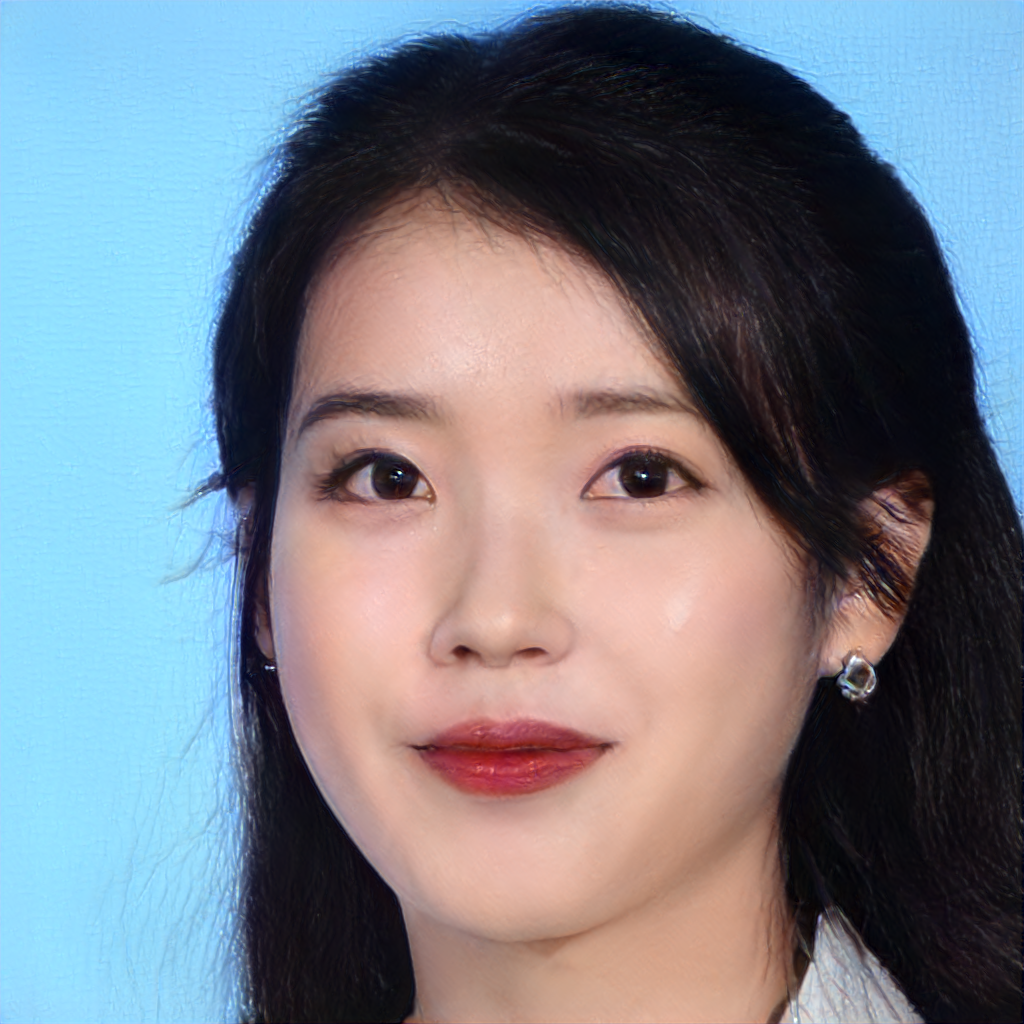

In [17]:
import os

dir1 = '/content/stylegan2/generated_images_no_tiled/'

sorted_file_name_list = sorted([ f for f in os.listdir(dir1) if not f.endswith('.npy')])

print(sorted_file_name_list)  # this is the image we will apply our latent direction to
display_image_from_file(dir1+sorted_file_name_list[0])

# 3. Expression transfer

Expression transfer consists in the addition of:
- a latent vector,
- a scaled difference vector.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Boilerplate code

In [13]:
def redirect_image_name_to_npy(image_name):
  npy_name = image_name.replace('.png', '.npy')

  return npy_name

import numpy as np

def load_latent_vector(image_name):
  latent_vector_name = redirect_image_name_to_npy(image_name)

  w = np.load(latent_vector_name)

  w = np.expand_dims(w, axis=0)

  return w

In [18]:
def get_expression_folder_name():
  expression_folder_name = '/content/generators-with-stylegan2/latent_directions/'

  return expression_folder_name

In [19]:
def get_expression_vector_file_name(expression_name):
  input_expression_folder_name = get_expression_folder_name()
  expression_vector_file_name = input_expression_folder_name + expression_name + '.npy'

  return expression_vector_file_name

In [26]:
# 3. Render results

from pathlib import Path
import tensorflow as tf
import numpy as np
import PIL.Image

def apply_expression(index_A,
                    expression_name,
                    use_tiled_projector=True,
                    file_extension = '.jpg',
                    n=5,
                    size=256,
                    v_min=-30,
                    v_max=30,
                    truncation_psi=None,
                    verbose=False):
  output_folder_name = 'richard_result/'
  
  if use_tiled_projector:    
    output_folder_name = output_folder_name + 'tiled/'
    input_folder_name = 'generated_images_tiled/'    
  else:
    output_folder_name = output_folder_name + 'no_tiled/'
    input_folder_name = 'generated_images_no_tiled/'
  
  Path(output_folder_name).mkdir(parents=True, exist_ok=True)

  keyword='richard_result'

  offset = 1
  output_file_name = '{}{}{}'.format(
      output_folder_name,
      "richard's_glasses_transformation",
      file_extension)

  image_name_A = input_folder_name + sorted_file_name_list[index_A]

  w_A = load_latent_vector(image_name_A)

  v_expression = np.load("/content/stylegan2/latent_direction/glasses_latent_direction.npy")

  #print(v_expression)
  canvas = PIL.Image.new('RGB', (n * size, size))
  for i, u in enumerate(np.linspace(v_min, v_max, n)):
    w_new = w_A + u * v_expression

    if truncation_psi is not None:
      w_new = w_avg + (w_new - w_avg) * truncation_psi

    image = Gs.components.synthesis.run(w_new, **Gs_syn_kwargs)[0]

    image = PIL.Image.fromarray(image)
    image = image.resize((size, size), PIL.Image.LANCZOS)
    canvas.paste(image, (i * size, 0))

  if verbose:
    print('Saving {}'.format(output_file_name))
  canvas.save(output_file_name)

  return

In [ ]:
  
  expression_name = ""
  apply_expression(index_A=0,
                    expression_name="",
                    use_tiled_projector=False,
                    truncation_psi=.75)
  
  #the results will be created in '/content/stylegan2/expression/no_tiled/'

Let's see the results, as you can see there isn't a slow transition from no glasses to glasses, so I had to increase the amount of linear interpolant, to get results, AKA v_min and v_max in apply_expression().

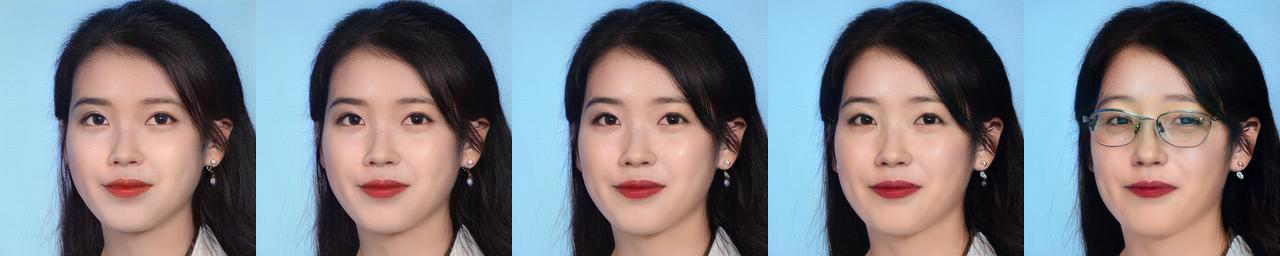

In [ ]:
display_image_from_file("/content/stylegan2/richard_result/no_tiled/richard's_glasses_transformation.jpg")

# Let's use the open source latent boundaries by https://github.com/a312863063/ and compare the results against mine.

In [20]:
%cd /content/
!rm -rf generators-with-stylegan2/
!git clone https://github.com/a312863063/generators-with-stylegan2.git
%cd /content/stylegan2

/content
Cloning into 'generators-with-stylegan2'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 618 (delta 6), reused 0 (delta 0), pack-reused 606
Receiving objects: 100% (618/618), 27.36 MiB | 16.01 MiB/s, done.
Resolving deltas: 100% (318/318), done.
/content/stylegan2


In [21]:
import os
f = get_expression_folder_name()
list_of_expressions = [g.replace('.npy', '') for g in sorted(os.listdir(f))]
print('\n'.join(list_of_expressions))

age
angle_horizontal
angle_pitch
beauty
emotion_angry
emotion_disgust
emotion_easy
emotion_fear
emotion_happy
emotion_sad
emotion_surprise
eyes_open
face_shape
gender
glasses
height
race_black
race_white
race_yellow
smile
width


In [27]:
from pathlib import Path
import tensorflow as tf
import numpy as np
import PIL.Image

def apply_a312863063_expression(index_A,
                    expression_name,
                    use_tiled_projector=True,
                    file_extension = '.jpg',
                    n=10,
                    size=256,
                    v_min=-30,
                    v_max=30,
                    truncation_psi=None,
                    verbose=False):
  output_folder_name = 'expression/'
  
  if use_tiled_projector:    
    output_folder_name = output_folder_name + 'tiled/'
    input_folder_name = 'generated_images_tiled/'    
  else:
    output_folder_name = output_folder_name + 'no_tiled/'
    input_folder_name = 'generated_images_no_tiled/'
  
  Path(output_folder_name).mkdir(parents=True, exist_ok=True)

  keyword='expression'

  offset = 1
  output_file_name = '{}{}_{:02d}_{}{}'.format(
      output_folder_name,
      keyword,
      index_A + offset,
      expression_name,
      file_extension)

  image_name_A = input_folder_name + sorted_file_name_list[index_A]

  w_A = load_latent_vector(image_name_A)

  expression_vector_file_name = get_expression_vector_file_name(expression_name)
  v_expression = np.load(expression_vector_file_name)

  canvas = PIL.Image.new('RGB', (n * size, size))
  for i, u in enumerate(np.linspace(v_min, v_max, n)):
    w_new = w_A + u * v_expression

    if truncation_psi is not None:
      w_new = w_avg + (w_new - w_avg) * truncation_psi

    image = Gs.components.synthesis.run(w_new, **Gs_syn_kwargs)[0]

    image = PIL.Image.fromarray(image)
    image = image.resize((size, size), PIL.Image.LANCZOS)
    canvas.paste(image, (i * size, 0))

  if verbose:
    print('Saving {}'.format(output_file_name))
  canvas.save(output_file_name)

  return

In [29]:

apply_a312863063_expression(index_A=0,
                  expression_name="glasses",
                  use_tiled_projector=False,
                  truncation_psi=.75)


# Results, a312863063's results vs mine.

Conclufsion:
The a312863063's results seem to suffer from feature entanglement, increasing the linear interpolant to also alters the girl's age.

a312863063's

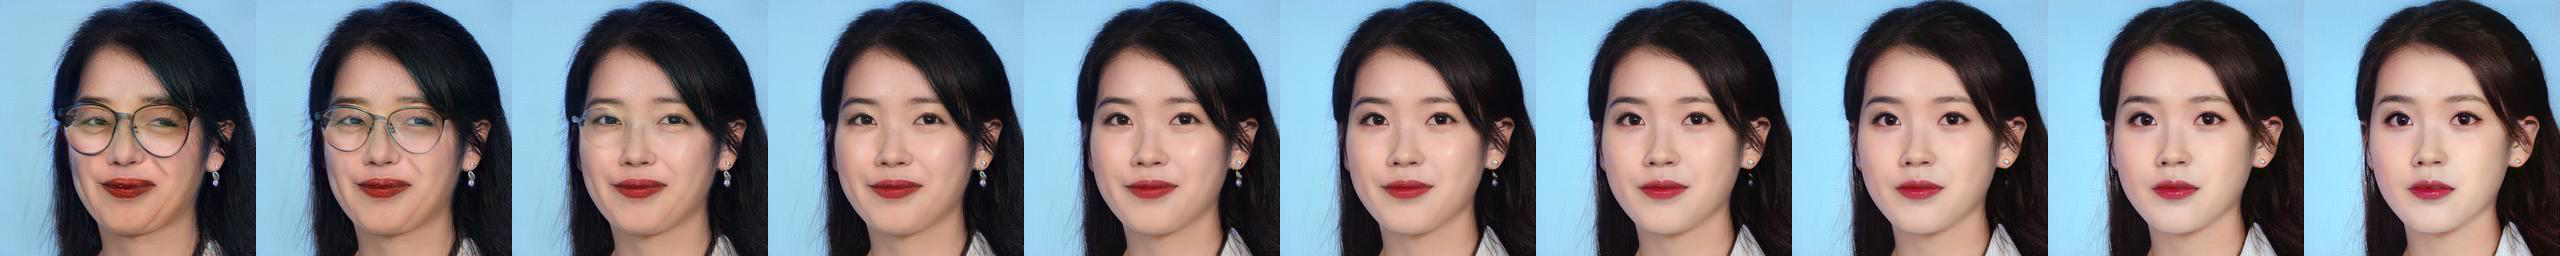

In [30]:
display_image_from_file("/content/stylegan2/expression/no_tiled/expression_01_glasses.jpg")

My result: I'm happy with this result.

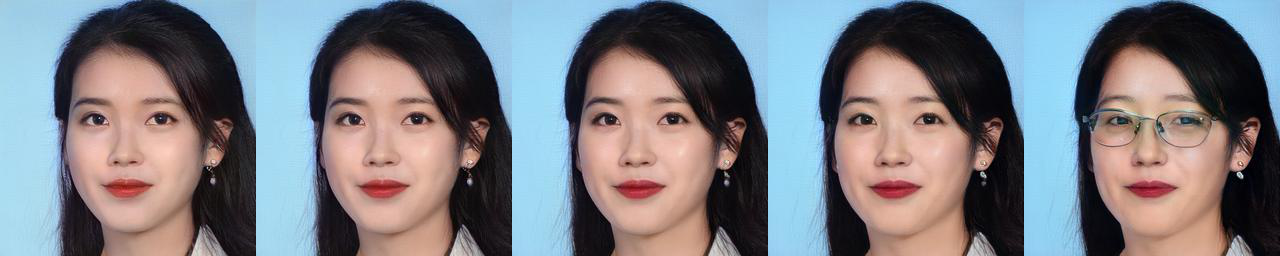

In [ ]:
display_image_from_file("/content/stylegan2/richard_result/no_tiled/richard's_glasses_transformation.jpg")

#Using open source boundaries to modify other facial expressions.

Let's make her smile.


In [36]:
apply_a312863063_expression(index_A=0,
                  expression_name="smile",
                  use_tiled_projector=False,
                  n =5,
                  v_min = -10,
                  v_max = 10,
                  truncation_psi=.75)

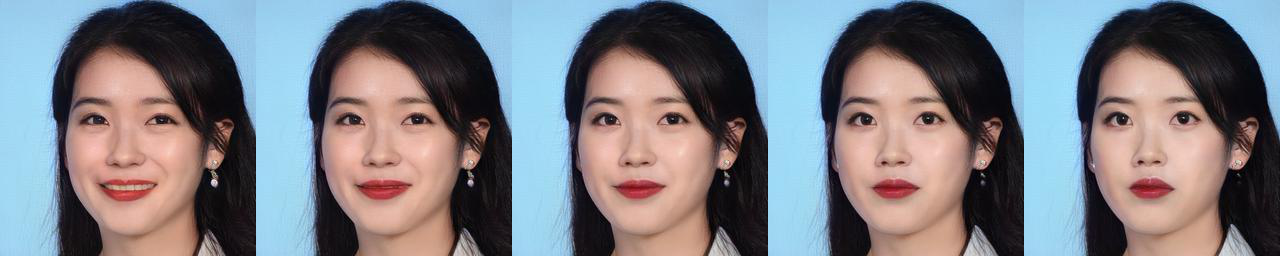

In [37]:
display_image_from_file("/content/stylegan2/expression/no_tiled/expression_01_smile.jpg")
